# Summary
- [Data](#Data)
- [Model](#Model)
- [Training](#Training)
    - [10-fold-cross-validation-(early-stopping)](#10-fold-cross-validation-(early-stopping))

In [1]:

#visualization
import matplotlib.pyplot as plt
#math tools
import numpy as np
from sklearn.preprocessing import normalize
from sklearn.preprocessing import scale
from sklearn.preprocessing import MinMaxScaler
from scipy.signal import resample
from scipy.signal import decimate
#machine learning
import torch
from sklearn.model_selection import StratifiedKFold
USE_CUDA = torch.cuda.is_available()
device = torch.device("cuda" if USE_CUDA else "cpu")
print(device)
#utils
from time import time
import warnings
from os.path import join
from os import listdir
import pickle

#custom
from utils import *
from load_data import *
from model import Model
from encoder import Encoder
from training import *

cuda


#  Utils

In [14]:

def plot(plot_i,train,valid,test,average=True,ylim=None):
    if average:
        print(str((task_i,is_lstm,learning_rate,hidden_size,num_layers,bidirectional,
        dropout,clip,window_size)).replace(",","|"))
        if early_stopping:
            title = "average {} over 10 folds over the {} first epochs".format(index2plot[plot_i],shortest_fold)
        else:
            title = "average {} over 10 folds over {} epochs".format(index2plot[plot_i],n_epochs)
    else :
        train,test=np.asarray(train),np.asarray(test)
        if valid:
            valid=np.asarray(valid)
        title=str((task_i,is_lstm,learning_rate,hidden_size,num_layers,bidirectional,
    dropout,clip,window_size))
    plt.figure()
    plt.title(title)
    plt.ylim(ylim)
    plt.plot(train[:,plot_i],label="training")
    if valid:
        plt.plot(valid[:,plot_i],label="validation")
    plt.plot(test[:,plot_i],label="test")
    plt.xlabel("epochs")
    plt.ylabel(index2plot[plot_i])
    plt.legend()

def return_results(train_metrics,valid_metrics,test_metrics,stopped_at,flat_falses):
    train_metrics,test_metrics=np.asarray(train_metrics),np.asarray(test_metrics)
    if early_stopping:
        valid_metrics=np.asarray(valid_metrics)
        str_valid_metrics="{:.2f} (± {:.2f})".format(np.mean(valid_metrics[:,1]),np.std(valid_metrics[:,1]))
    else:
        str_valid_metrics="NA"
    
    model_name="LSTM" if is_lstm else "GRU"
    task_name=index2task[task_i] if task_i is not None else str(task_i)
    results="{} ; {} ; {} ; {}   ; {} ; {} ; {} ; {} ; {:.2f} (± {:.2f}) ; None ; {} ; {} ; NA ; {} ; TRUE ; {:.2f} (± {:.2f}) ; {} ".format(
    task_name,model_name,learning_rate, hidden_size,num_layers,bidirectional,dropout,clip,
    np.mean(stopped_at),np.std(stopped_at),compute_movement,early_stopping,downsampling_factor,
     np.mean(train_metrics[:,1]),np.std(train_metrics[:,1]), str_valid_metrics)

    test_metrics=test_metrics.T
    for metric in test_metrics[1:]:#don't care about the loss
        mean,std=np.mean(metric),np.std(metric)
        results+="; {:.2f} (± {:.2f}) ".format(mean,std)
    results+=" ; "
    results+=" ; ".join(map(str, flat_falses))
    return results
def print_results():
    try:
        if early_stopping:
            folds_lengths=[len(fold) for fold in fold_valid_metrics]
            assert np.max(folds_lengths) < n_epochs
            print("number of epochs before early stopping for each fold:\n",folds_lengths)
            longest_fold=np.argmax(folds_lengths)
            shortest_fold=np.min(folds_lengths)
            average_stop=int(round(np.mean(folds_lengths)-patience))-1#-1 to index to it
            med_stop=int(round(np.median(folds_lengths)-patience-1))#-1 to index to it
            best_index=-patience-1
            stopped_at=[len(fold)-patience for fold in fold_valid_metrics]
        else:
            best_index=np.argmax(np.mean(fold_test_metrics,axis=0)[:,1])      
            stopped_at=[best_index+1]
    except AssertionError:
        print("The model didn't early stop therefore fold[-patience-1] is not the best epoch")    
    else:    
        best_falses=[fold[best_index] for fold in fold_falses]
        flat_falses = sorted(flat_list(best_falses))
        results=return_results([fold[best_index] for fold in fold_train_metrics],
                      None,#[fold[best_index] for fold in fold_valid_metrics],
                      [fold[best_index] for fold in fold_test_metrics],
                      stopped_at,
                       flat_falses)
        print(results)

# Data
Cf `load_data.py`
## Loading

## Task selection
set `task_i` to None if you want to train the model on all tasks at once (i.e. early fusion)  
Else set `task_i` to the desired task index (cf. task2index)

## Compute movement
Transforms data as Zhang et al. (cf Report #5)

## Scale then downsample (or not) then concatenate task id (or not)
Set `downsampling_factor` to `1` if you don't want to downsample
## Split in subsequence (or not)
Set `window_size` to `None` if you don't want to split data into subsequence of fixed length  
Set `paper_air_split` to `False` if you don't want to split data into strokes

In [3]:
## Loading
#Cf `load_data.py`
task_i=task2index["l"]
compute_movement=False
downsampling_factor=10
window_size=None
paper_air_split=True
try:
    assert window_size is None or not paper_air_split
except AssertionError:
    print("you have to choose between subsequences of fixed length and strokes !")
else:
    print("\nloading and massaging data, this might take a few seconds...")
    data_gen=load_data()
    data,targets=[],[]
    for subject,label in data_gen:
        data.append(subject)
        targets.append(label)
    print("(75-3 subjects, 8 tasks, X timesteps, 7 measures)")
    print(len(data),len(data[0]),len(data[0][0]),len(data[0][0][0]))
    data, targets= massage_data(data, targets,task_i, compute_movement, downsampling_factor, window_size,paper_air_split)
    
    


loading and massaging data, this might take a few seconds...
(75-3 subjects, 8 tasks, X timesteps, 7 measures)
72 8 1772 7

task index, name
1 l
len(data), len(targets), len(data[0]) :
72 72 928

movement was not computed (i.e. data was not transformed)

scaling and downsampling

len(data), len(targets), len(data[0]) :
72 72 93

splitting data into strokes
len(data), data[0].shape, total n° of subsequences (i.e. training examples) :
72 , 9 13 7 , 697


### Merging strokes into letters

Subjects 12, 21, 23,  44, 67 did 6 l instead of 5

In [4]:
for j in range(len(data)):
    tmp=[]
    for i in range(0,len(data[j]),2):
        try : 
            data[j][i+1]
        except IndexError:
            tmp.append(data[j][i])
        else:
            tmp.append(np.concatenate((data[j][i],data[j][i+1]),axis=0))
    data[j]=tmp
def pop(i,j):
    data[i][j-1]=np.concatenate((data[i][j-1],data[i][j]))
    data[i].pop(j)
pop(22,1)
pop(26,2)
pop(36,5)
pop(37,1)
pop(41,4)
pop(46,4)
pop(48,1)
pop(3,4)
pop(3,2)
#pop(6,5)
#pop(6,3)
pop(6,4)
pop(14,6)
pop(14,4)
pop(14,2)
pop(16,6)
pop(16,4)
pop(16,2)
pop(21,5)
pop(71,6)
pop(71,2)

assert [i for i,s in enumerate(data) if len(s) != 5]==[12, 21, 23, 44, 67]


In [19]:
sum([len(i) for i in data])

365

# Model
- [**Pytorch LSTM doc**](https://pytorch.org/docs/stable/nn.html#torch.nn.LSTM)
- [**Pytorch Linear doc**](https://pytorch.org/docs/stable/nn.html#torch.nn.Linear)
- [**Pytorch Binary Cross Entropy loss (BCELoss) doc**](https://pytorch.org/docs/stable/nn.html#torch.nn.BCELoss)

## Definition
Cf. Report #4 for details about the architecture of the model

In [5]:
class Hierarchical(torch.nn.Module):
    """
    Args:
        input_size: The number of expected features in the input `x`
        hidden_size: The number of features in the hidden state `h`        
        bias: If ``False``, then the layer does not use bias weights `b_ih` and `b_hh`.
            Default: ``True``        
        dropout: If non-zero, introduces a `Dropout` layer on the outputs of each
        LSTM layer except the last layer, with dropout probability equal to
        :attr:`dropout`. Default: 0
        batch_size : default : 1
        output_size : default : 1
        is_lstm : default : True
    """
    def __init__(self, input_size, hidden_size, bias=True,dropout=0.0, batch_size=1,output_size=1,is_lstm=True):
        super(Hierarchical, self).__init__()
        #Vanilla LSTM
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bias=bias        
        self.dropout=dropout
        self.batch_size=batch_size
        self.output_size = output_size

        # Define the LSTM layers
        if is_lstm:
            self.layer1=torch.nn.LSTMCell(self.input_size,self.hidden_size,self.bias)
            self.layer2=torch.nn.LSTMCell(self.hidden_size,self.hidden_size,self.bias)
        else:
            self.layer1=torch.nn.GRUCell(self.input_size,self.hidden_size,self.bias)
            self.layer2=torch.nn.GRUCell(self.hidden_size,self.hidden_size,self.bias)
        
        #define the dropout layer
        self.dropout_layer=torch.nn.Dropout(self.dropout)

        # Define the decoder layer
        self.linear = torch.nn.Linear(self.hidden_size, self.output_size)
        self.sigmoid = torch.nn.Sigmoid()
        self.reset_hidden()
                
    def forward(self, input):
        """should take a subject as input
        with subject = [seq1, seq2, ..., seqn]"""
        layer1_hidden=[]
        for seq in input:
            #done before#seq=torch.Tensor(seq).unsqueeze(1).to(device)
            for timestep in seq:#forward pass through the seq
                if is_lstm:
                    self.h_0,self.c_0=self.layer1(timestep,(self.h_0,self.c_0))
                else:
                    self.h_0=self.layer1(timestep,self.h_0)
            layer1_hidden.append(self.h_0)#take only the last hidden state of the letter (i.e. the letter encoding)
        for hidden in layer1_hidden:#feed all the letters encoding to the 2nd layer
            self.dropout_layer(hidden)#we could either apply the feedforward dropout here or on : `layer1_hidden.append(h_0) `
            if is_lstm:
                self.h_1,self.c_1=self.layer2(hidden,(self.h_1,self.c_1))
            else:
                self.h_1=self.layer2(hidden,self.h_1)
    
        # Only take the output from the final timestep
        drop=self.dropout_layer(self.h_1)
        y_pred = self.linear(drop)
        y_pred = self.sigmoid(y_pred)
        return y_pred.squeeze(0)
    
    def reset_hidden(self,device="cuda"):
        """
        tensor containing the initial cell state for each element in the batch.

        The hidden state(s) is (are) modified in place."""

        self.h_0=torch.zeros(self.batch_size, self.hidden_size,device=device)
        self.h_1=torch.zeros(self.batch_size, self.hidden_size,device=device)
        if is_lstm:
            self.c_0=torch.zeros(self.batch_size, self.hidden_size,device=device)
            self.c_1=torch.zeros(self.batch_size, self.hidden_size,device=device)
    
    def init_forget_bias(self):
        """Following advices of Jozefowicz et al. 2015,
        we initialize the bias of the forget gate to a large value such as 1
        In PyTorch, the forget gate bias is stored as b_hf in bias_hh_l[k] : 
        the learnable hidden-hidden bias of the kth layer (b_hi|b_hf|b_hg|b_ho), of shape (4*hidden_size).
        So b_hf == bias_hh_lk[hidden_size:2*hidden_size]
        
        The weights are modified in-place, like init_hidden(self).
        """
        
        with torch.no_grad():#so the optimizer doesn't know about this ;)
            self.layer1.bias_hh_l0[hidden_size:2*hidden_size]=torch.ones(self.hidden_size)
            
            self.layer2.bias_hh_l0[hidden_size:2*hidden_size]=torch.ones(self.hidden_size)
                
    def count_params(self):
        """returns (total n° of parameters, n° of trainable parameters)"""
        total_params = sum(p.numel() for p in self.parameters())
        trainable_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
        return total_params, trainable_params


# Training

In [6]:
hierarchical=True#this is only used in the training step, it doesnt set the model
is_lstm=False
augmentation=False
learning_rate = 1e-3
batch_size=1
hidden_size=10
dropout=0.0
clip=5.0#clipping value to clip the gradients norm : set to None if you don't want to clip

num_layers,bidirectional=2,False#these are not parametrable for the hierarchical model

"""#if we perform single task learning on the whole sequence
if task_i is not None and window_size is None and not paper_air_split:
    input_size=len(data[0][0])#==7 if we take all the measures into account
else:
    input_size=len(data[0][0][0])#==7+8 if we train on multiple tasks, 7 if we train on subsequences (and single task)
"""
input_size=7
print("input_size :",input_size)
bias=True
batch_first=False#we should unsqueeze(1) to add a batch dimension
batch_size=1
output_size=1#binary classif : 1 means PD, 0 means control

loss_fn=torch.nn.BCELoss()#Binary cross entropy
paper_air_split=False#set to false to have regular training (see epoch)

input_size : 7


In [7]:

run_CV=False#if False, breaks after one fold, else runs CV
early_stopping=False
n_epochs=15#max n° of epochs the model will be trained to
#n° of epochs without improvement during which the model will wait before stopping (if early_stopping)
#useless if not early_stopping
patience = 10
verbose=False
fold_train_metrics,fold_test_metrics,fold_falses=[],[],[]
start = time()
np.random.seed(1)
save_to_print=""

skf = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
cv_generator=skf.split(data,targets)

for fold,(train_index,test_index) in enumerate(cv_generator):      
    train_metrics,test_metrics,falses=[],[],[]

    torch.manual_seed(1)#random seed for weights init
    model= Hierarchical(input_size, hidden_size, bias, dropout,batch_size,output_size, is_lstm).to(device)
    if isinstance(model,torch.nn.LSTM):
        model.init_forget_bias()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    if fold==0:        
        print("(total n° of parameters, n° of trainable parameters)")
        print(model.count_params())

    best_accuracy=0
    #best_loss=10000.0
    impatience=0
    for i in range(n_epochs):                
        to_print=""
        np.random.shuffle(train_index)#shuffle training to facilitate SGD        
        #training
        model.train()
        [loss,accuracy,sensitivity,specificity,ppv,npv],_=epoch(
        data, targets, model, optimizer, loss_fn, batch_size, train_index,device=device,hierarchical=hierarchical,
            clip=clip,validation=False,window_size=window_size,task_i=task_i,augmentation=augmentation,paper_air_split=paper_air_split)
        train_metrics.append([loss,accuracy,sensitivity,specificity,ppv,npv])
        to_print+="\n\nfold n°{}, epoch n°{}, spent {}".format(fold,i,timeSince(start))
        to_print+="\nTRAINING : loss {:.3f}, accuracy {:.3f}".format(loss,accuracy)

        #test
        [loss,accuracy,sensitivity,specificity,ppv,npv],false=epoch(
            data, targets, model, optimizer, loss_fn, batch_size, test_index,device=device,hierarchical=hierarchical,
            validation=True,window_size=window_size,task_i=task_i,augmentation=False,paper_air_split=paper_air_split)    
        test_metrics.append([loss,accuracy,sensitivity,specificity,ppv,npv])
        falses.append(false)
        to_print+="\nTEST : loss {:.3f}, accuracy {:.3f}, sensitivity  {:.3f}, specificity {:.3f}, ppv {:.3f}, npv {:.3f}".format(
            loss,accuracy,sensitivity,specificity,ppv,npv)       

        #patience update
        #useless if not early stopping
        if accuracy <= best_accuracy:#`<=` no improvement is considered bad !#loss>=best_loss:
            impatience+=1
        else:
            best_accuracy=accuracy #best_loss=loss#
            impatience=0
        if verbose:
            print(to_print)
        save_to_print+=to_print
        #early stopping
        if impatience >= patience and early_stopping:
            save_to_print+="\nEarly stopped."
            break     

    fold_train_metrics.append(train_metrics)
    fold_test_metrics.append(test_metrics)
    fold_falses.append(falses)
    if not run_CV:
        break
if not verbose:
    print(to_print)#save_to_print)

if run_CV:   
    # Save metrics
    filename=join("experiments","x_y"+str((task_i,is_lstm,learning_rate,hidden_size,num_layers,bidirectional,
    dropout,clip,window_size)))
    for metrics,metric_type in list(zip([fold_train_metrics,
    fold_test_metrics],["train","test"])):
        with open(filename+metric_type, 'wb') as fp:
            pickle.dump(metrics, fp)
    
    print_results() 

(total n° of parameters, n° of trainable parameters)
(1241, 1241)


fold n°0, epoch n°14, spent 0m 47s
TRAINING : loss 0.678, accuracy 0.531
TEST : loss 0.721, accuracy 0.250, sensitivity  0.250, specificity 0.250, ppv 0.250, npv 0.250


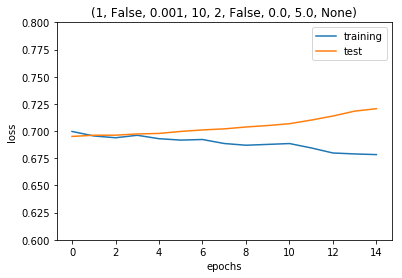

In [18]:
plot(0,train_metrics,None,test_metrics,False,(0.6,0.8))

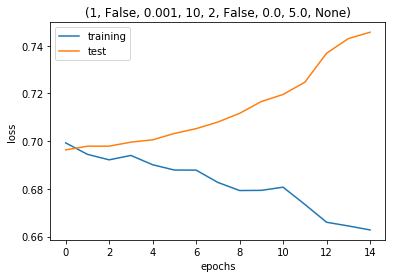

In [25]:
plot(0,train_metrics,None,test_metrics,False)

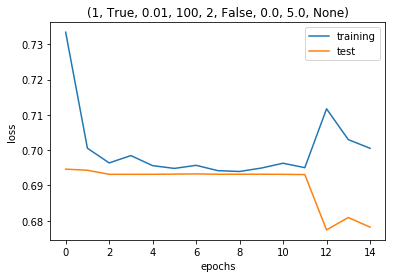

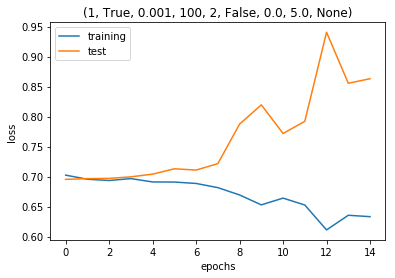

In [17]:
plot(0,train_metrics,None,test_metrics,False)